<font size="+3"><strong>5.3. Ensemble Models: Random Forest</strong></font>

In [2]:
import gzip
import json
import pickle
import re  # Import the regular expression module


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline


from scipy.io.arff import loadarff  # Import loadarff


# Prepare Data

**Task 5.3.1:** Complete the `wrangle` function below using the code you developed in the  lesson 5.1. Then use it to import `poland-bankruptcy-data-2009.json.gz` into the DataFrame `df`.


In [3]:
def wrangle(filename):
    # Load ARFF file
    data, meta = loadarff(filename)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Rename columns
    df.columns = [re.sub(pattern='Attr',repl='feat_',string=col) for col in df.columns]
    df.rename(columns={'class':'bankrupt'},inplace=True)
    
    # Change dtype of the Labels columns
    df['bankrupt'] = df['bankrupt'].astype(np.int64)

    return df

In [4]:
df = wrangle("../data/raw/2year.arff")
print(df.shape)
df.head()

(10173, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,0.42695,...,0.13184,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,0
1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,0.40437,...,0.12146,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,0
2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,0.69841,...,0.16499,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,0
3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,0.32150,...,0.29358,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,0
4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,0.52167,...,0.10124,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,0


**Task 5.3.2:** Create your feature matrix `X` and target vector `y`. Your target is `"bankrupt"`. 

In [5]:
target = "bankrupt"
X = df.drop(columns="bankrupt")
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10173, 64)
y shape: (10173,)


**Task 5.3.3:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8138, 64)
y_train shape: (8138,)
X_test shape: (2035, 64)
y_test shape: (2035,)


**Task 5.3.4:** Create a new feature matrix `X_train_over` and target vector `y_train_over` by performing random over-sampling on the training data.


In [7]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (15618, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,-0.192570,0.35227,0.510510,2.47700,26.790,-0.204360,-0.192570,1.83870,1.5966,0.64773,...,9240.60,-0.229590,-0.29730,1.10780,0.000000,4.3649,4.4739,79.015,4.6194,11.0980
1,0.049627,0.57736,0.068764,1.34300,13.889,0.356470,0.056439,0.73202,1.3626,0.42264,...,212.00,0.029517,0.11742,0.95991,0.574060,76.3820,5.5716,53.694,6.7977,1.8646
2,0.041653,0.69981,0.105580,1.15400,-67.647,-0.244890,0.041653,0.42896,2.5568,0.30019,...,908.47,0.329970,0.13876,0.67228,0.008447,7.7514,6.7573,97.898,3.7284,12.2530
3,0.072353,0.41568,-0.069933,0.79088,-19.469,0.156670,0.072353,1.21350,1.0147,0.50441,...,-1376.90,0.014466,0.14344,0.98553,0.161110,31.8390,24.6310,34.355,10.6240,4.8305
4,0.030057,0.89885,0.076174,1.08640,-54.415,-0.000038,0.035324,0.11254,2.4688,0.10115,...,359.88,0.038305,0.29714,0.98572,0.117300,5.7059,4.7257,130.290,2.8014,57.9880


**Task 5.3.5:** Calculate the baseline accuracy score for your model.


In [8]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9596


**Task 5.3.6:** Create a pipeline named `clf` (short for "classifier") that contains a `SimpleImputer` transformer and a `RandomForestClassifier` predictor.

In [9]:
clf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


**Task 5.3.7:** Perform cross-validation with your classifier, using the over-sampled training data. We want five folds, so set `cv` to 5. We also want to speed up training, to set `n_jobs` to -1.


In [10]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

[0.99807939 0.99903969 0.99679898 0.99839898 0.99775857]


**Task 5.3.8:** Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier. 


In [11]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

**Task 5.3.9:** Create a `GridSearchCV` named `model` that includes your classifier and hyperparameter grid. Be sure to use the same arguments for `cv` and `n_jobs` that you used above, and set `verbose` to 1. 


In [12]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

**Task 5.3.10:** Fit `model` to the over-sampled training data.

In [13]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

**Task 5.3.11:** Extract the cross-validation results from `model` and load them into a DataFrame named `cv_results`.


In [14]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.937744,0.932191,0.059777,0.005281,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.988476,0.981434,0.979513,0.983029,0.984310,0.983353,0.003023,21
1,4.348479,0.573269,0.049024,0.014005,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.983995,0.980154,0.979193,0.980147,0.980467,0.980791,0.001658,23
2,9.316851,1.010637,0.066122,0.008771,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.985915,0.982074,0.979834,0.985591,0.984310,0.983545,0.002295,20
3,9.709468,1.498169,0.068180,0.015195,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.981434,0.979834,0.977273,0.983349,0.980147,0.980407,0.001997,24
4,14.701912,1.069229,0.114161,0.029400,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.987516,0.983355,0.981434,0.985591,0.983990,0.984377,0.002058,19
5,13.551367,1.782324,0.123910,0.050723,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.983035,0.982714,0.977273,0.983990,0.983349,0.982072,0.002436,22
6,5.636887,0.514633,0.065697,0.031606,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.998399,0.998079,0.995519,0.996798,0.997118,0.997183,0.001020,17
7,5.349528,0.555090,0.051165,0.011951,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.997439,0.996799,0.995519,0.997438,0.996798,0.996799,0.000701,18
8,12.256572,0.700422,0.091897,0.022020,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.997759,0.998720,0.995519,0.997759,0.997118,0.997375,0.001060,14
9,11.271796,1.169161,0.087938,0.022896,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.997439,0.998079,0.996159,0.997438,0.997118,0.997247,0.000627,15


**Task 5.3.12:** Create a mask for `cv_results` for rows where `"param_randomforestclassifier__max_depth"` equals 10. Then plot `"param_randomforestclassifier__n_estimators"` on the x-axis and `"mean_fit_time"` on the y-axis. Don't forget to label your axes and include a title. 


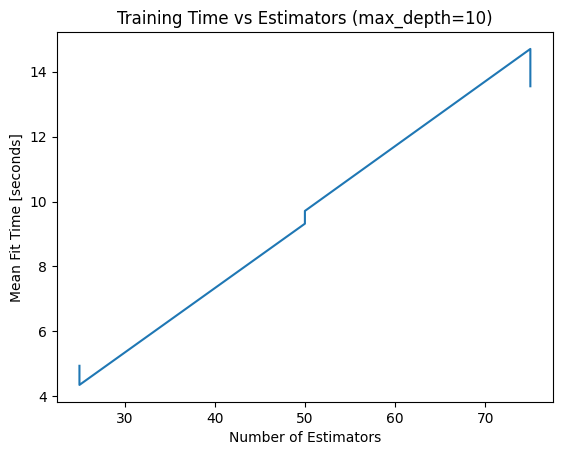

In [15]:
# Create mask
mask = cv_results["param_randomforestclassifier__max_depth"] == 10
# Plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

**Task 5.3.13:** Create a mask for `cv_results` for rows where `"param_randomforestclassifier__n_estimators"` equals 25. Then plot `"param_randomforestclassifier__max_depth"` on the x-axis and `"mean_fit_time"` on the y-axis. Don't forget to label your axes and include a title. 


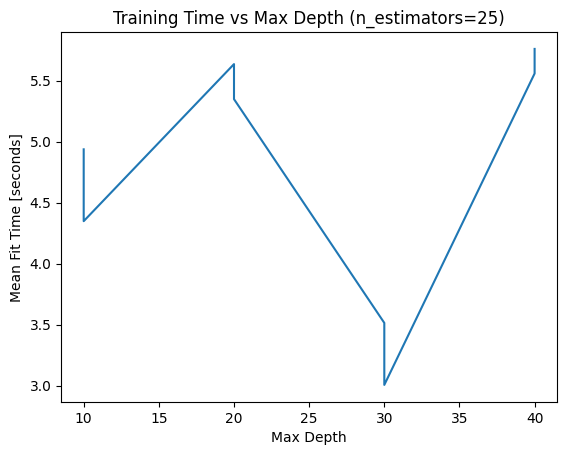

In [16]:
# Create mask
mask = cv_results["param_randomforestclassifier__n_estimators"] == 25
# Plot fit time vs max_depth
plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

**Task 5.3.14:** Extract the best hyperparameters from `model`.


In [17]:
# Extract best hyperparameters
model.predict(X_train_over)

array([0, 0, 0, ..., 1, 1, 1])

**Task 5.3.15:** Calculate the training and test accuracy scores for `model`. 


In [18]:

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9715


In [19]:
y_test.value_counts()

bankrupt
0    1964
1      71
Name: count, dtype: int64

**Task 5.3.16:** Plot a confusion matrix that shows how your best model performs on your test set. 


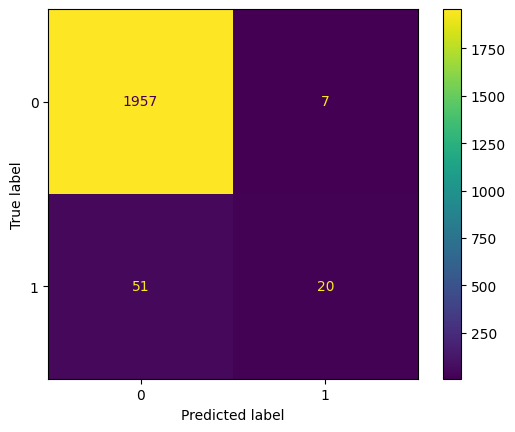

In [20]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

**Task 5.3.17:** Create a horizontal bar chart with the 10 most important features for your model. 

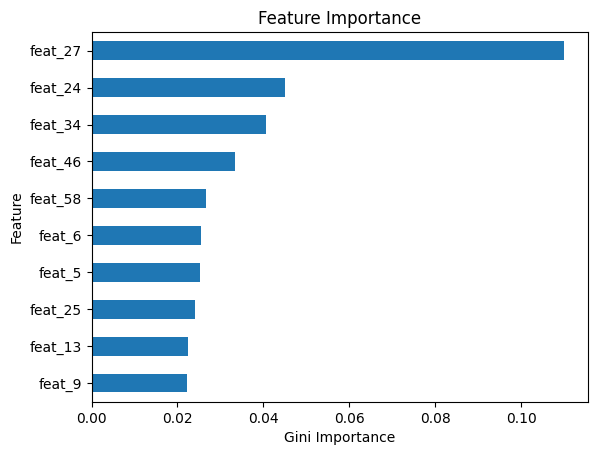

In [21]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind = "barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

**Task 5.3.18:** Using a context manager, save your best-performing model to a a file named `"model-5-3.pkl"`. 


In [22]:
# Save model
with open("model-5-3.pkl", "wb") as f:
    pickle.dump(model, f)

**Task 5.3.19:** Create a function `make_predictions`. It should take two arguments: the path of a JSON file that contains test data and the path of a serialized model. The function should load and clean the data using the `wrangle` function you created, load the model, generate an array of predictions, and convert that array into a Series. (The Series should have the name `"bankrupt"` and the same index labels as the test data.) Finally, the function should return its predictions as a Series. 


In [23]:
def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="bankrupt")
    return y_test_pred

**Task 5.3.20:** Use the code below to check your `make_predictions` function. Once you're satisfied with the result, submit it to the grader. 

In [ ]:

y_test_pred = make_predictions(
    data_filepath="../data/raw/1year.arff",
    model_filepath="model-5-3.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()